# Dustin Bracy 
## ML2 HW4

**HW4 Instructions**

Below you see a tutorial from Keras on using transfer learning.  They train their models on half of the digits and predict the second half.  Your homework is to train on all digits and make your own handwritten data set of 5 characters (ie A, B, C, D, E) and transfer your minist trained model over to them.  Enjoy!


## Setup

In [4]:

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
import os
from PIL import Image


def plot_training_curves(history, title=None):
    """ 
    Plot the training curves for loss and accuracy given a model history
    """
    # find the minimum loss epoch
    minimum = np.min(history.history["val_loss"])
    min_loc = np.where(minimum == history.history["val_loss"])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (
        min(history.history["val_loss"] + history.history["loss"]),
        max(history.history["val_loss"] + history.history["loss"]),
    )
    acc_min, acc_max = (
        min(history.history["val_accuracy"] + history.history["accuracy"]),
        max(history.history["val_accuracy"] + history.history["accuracy"]),
    )
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history["accuracy"]) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history["loss"], label="loss")
    ax[0].plot(index, history.history["val_loss"], label="val_loss")
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label="min_loss_location")
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history["accuracy"], label="accuracy")
    ax[1].plot(index, history.history["val_accuracy"], label="val_accuracy")
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label="min_loss_location")
    ax[1].set_title("Accuracy")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    plt.show()


def image_converter(input_dir: str, output_dir: str):
    """Convertes images from ./letters/originals and places in ./letters/formatted
    """
    images = os.listdir(input_dir)
    for image in images:
        try:
            with Image.open(input_dir + image) as im:
                box = (30, 50, 175, 195)
                # enh = ImageEnhance.Contrast(im)
                # im = enh.enhance(1.2)
                new_size = (28, 28)
                outfile = im.convert("L").crop(box).resize(new_size)
                outfile.save(output_dir + image)

        except OSError as err:
            print("cannot convert", image, "OS error: {0}".format(err))
    print("Images converted to:", outfile.size, outfile.mode)


def get_images(convert: bool = False) -> tuple:
    """Fetches images to use in transfer learning.

    Arguments:
        Convert: calls image_converter()
    Returns:
        Tuple of (np.array images, np.array labels)
    """
    source_dir = "./letters/formatted/"
    if convert:
        image_converter(input_dir="./letters/originals/", output_dir=source_dir)
    image_files = os.listdir(source_dir)
    images = []
    labels = []
    for image in image_files:
        labels.append(image[0])  # first char of filename
        with Image.open(source_dir + image) as im:
            images.append(np.array(im))
    return np.asarray(images), np.asarray(labels)


def data_peek(data):
    # Look at some random numbers
    X_shuffle = shuffle(data.copy(), random_state=42)

    print("Look at some random images\n")
    plt.figure(figsize=(12, 10))
    row, colums = 4, 4
    for i in range(16):
        plt.subplot(colums, row, i + 1)
        plt.imshow(X_shuffle[i].reshape(28, 28), interpolation="nearest", cmap="Greys")
    return plt.show()


## Loading the data

In [5]:
# load MNIST (training) dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


# load letters (inference) dataset
letters = get_images()

# split letters into test/train
x_train_letters, x_test_letters, y_train_letters, y_test_letters = train_test_split(
    *letters, test_size=0.2, random_state=86
)

# scale data + add the color channel ("L")
def scale_data(data):
    color_depth = 255
    return data / color_depth


def add_color(data):
    return data.reshape(data.shape + (1,))


x_train = add_color(scale_data(x_train))
x_test = add_color(scale_data(x_test))
x_train_letters = add_color(scale_data(x_train_letters))
x_test_letters = add_color(scale_data(x_test_letters))

# convert alpha labels to numeric:
def to_numeric(data):
    ord_start = ord("A")
    return np.asarray([ord(y) - ord_start for y in data])


y_train_letters = to_numeric(y_train_letters)
y_test_letters = to_numeric(y_test_letters)

## Look at the data

In [18]:
print(x_train.shape, '\n', x_train_letters.shape)
print(y_test[:10])

(60000, 28, 28, 1) 
 (240, 28, 28, 1)
[7 2 1 0 4 1 4 9 5 9]


In [20]:
print(x_test.shape, '\n', x_test_letters.shape)
print(y_test_letters[:10])
print([chr(y+ord('A')) for y in y_test_letters][:10])

(10000, 28, 28, 1) 
 (60, 28, 28, 1)
[4 3 0 0 1 3 4 2 0 4]
['E', 'D', 'A', 'A', 'B', 'D', 'E', 'C', 'A', 'E']


Look at some random images



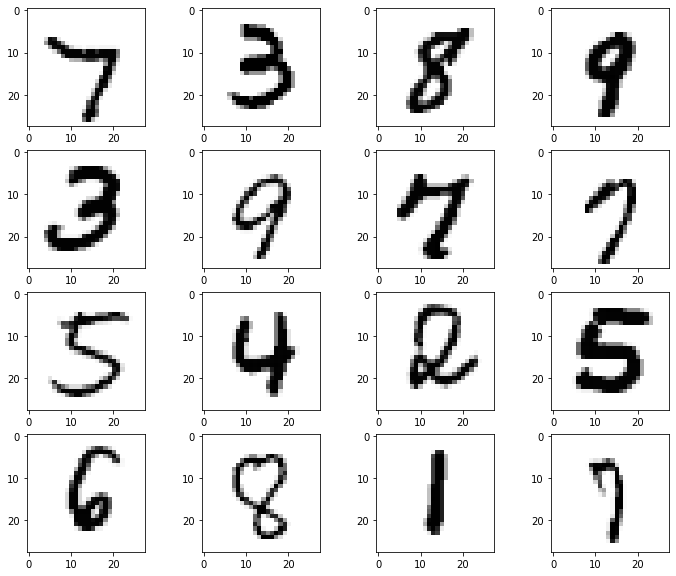

Look at some random images



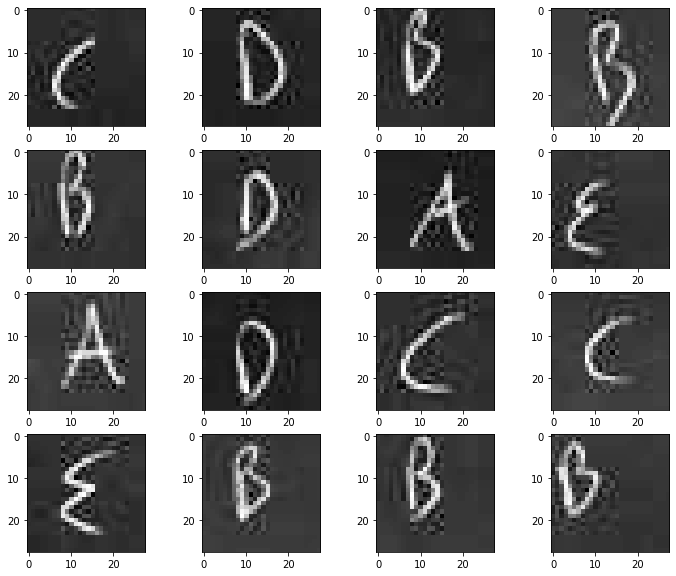

In [3]:
data_peek(x_train)
data_peek(x_train_letters)

## Model Setup

In [4]:
num_classes = 10
filters = 32
pool_size = 2
kernel_size = 3
dropout = 0.2
input_shape = (28, 28, 1)

model = Sequential(
    [
        # convolutional feature extraction
        # ConvNet 1
        keras.layers.Conv2D(
            filters,
            kernel_size,
            padding="valid",
            activation="relu",
            input_shape=input_shape,
        ),
        keras.layers.MaxPooling2D(pool_size=pool_size),
        # ConvNet 2
        keras.layers.Conv2D(filters, kernel_size, padding="valid", activation="relu"),
        keras.layers.MaxPooling2D(pool_size=pool_size),
        # classification
        # will retrain from here
        keras.layers.Flatten(name="flatten"),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(dropout, name="penult"),
        keras.layers.Dense(num_classes, activation="softmax", name="last"),
    ]
)

# print summary of model as check
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

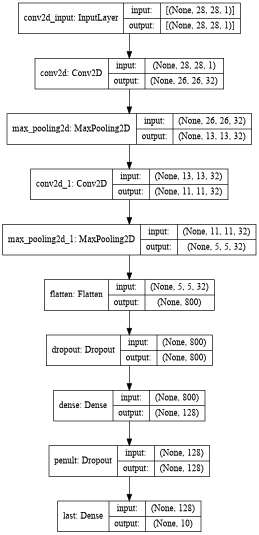

In [5]:
# print image of model as check
keras.utils.plot_model(model, show_shapes=True, dpi=48)


## Train Model

Epoch 1/1000
1500/1500 [==============================] - 113s 75ms/step - loss: 0.4275 - accuracy: 0.8652 - val_loss: 0.0645 - val_accuracy: 0.9802
Epoch 2/1000
1500/1500 [==============================] - 86s 57ms/step - loss: 0.0817 - accuracy: 0.9755 - val_loss: 0.0456 - val_accuracy: 0.9882
Epoch 3/1000
1500/1500 [==============================] - 83s 55ms/step - loss: 0.0540 - accuracy: 0.9827 - val_loss: 0.0436 - val_accuracy: 0.9875
Epoch 4/1000
1500/1500 [==============================] - 92s 61ms/step - loss: 0.0401 - accuracy: 0.9868 - val_loss: 0.0363 - val_accuracy: 0.9899
Epoch 5/1000
1500/1500 [==============================] - 81s 54ms/step - loss: 0.0389 - accuracy: 0.9873 - val_loss: 0.0379 - val_accuracy: 0.9897
Epoch 6/1000
1500/1500 [==============================] - 80s 53ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0340 - val_accuracy: 0.9906
Epoch 7/1000
1500/1500 [==============================] - 73s 49ms/step - loss: 0.0278 - accuracy: 0.9912 - val

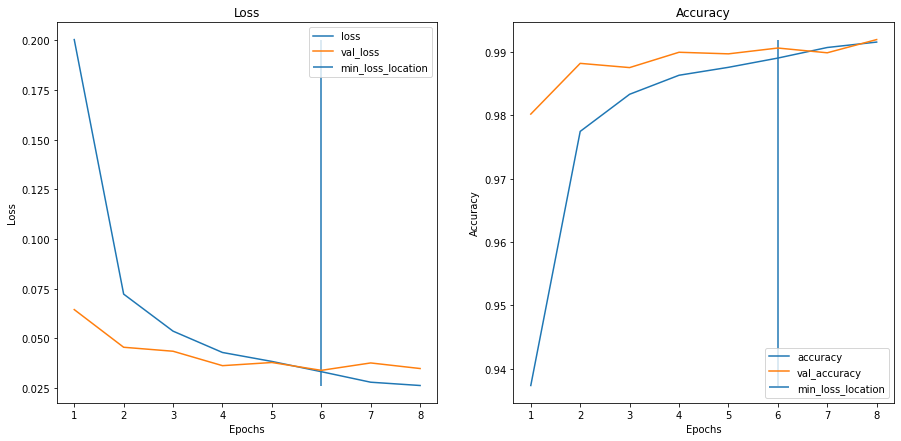

In [6]:
# Set early stopping criteria
es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=2)


model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

history = model.fit(
    x_train, y_train, validation_split=0.2, batch_size=32, epochs=1000, callbacks=[es]
)

plot_training_curves(history)

## Predictions

In [7]:
# predict using the model
preds = model.predict(x_test)
# argmax along rows to get classification
preds = np.argmax(preds, axis=1).astype("uint8")
print("accuracy:", accuracy_score(y_test, preds))


accuracy: 0.992


## Transfer Learning

In [9]:
# lock the ConvNet layers
layer_trainable = False
for layer in model.layers:
    layer.trainable = layer_trainable
    if layer.name == "flatten":
        layer_trainable = True

print(f"{'Layer Name':17} {'Is Trainable?'}")
for layer in model.layers:
    print(f"{layer.name:17} {layer.trainable}")

# get the penultimate layer of the model
penult_layer = model.get_layer(name="penult")

# create a new output layer
letter_classes = len(set(letters[1]))
output_layer = keras.layers.Dense(letter_classes, activation="softmax")(
    penult_layer.output
)

new_model = Model(model.input, output_layer)
new_model.summary()


Layer Name        Is Trainable?
conv2d            False
max_pooling2d     False
conv2d_1          False
max_pooling2d_1   False
flatten           False
dropout           True
dense             True
penult            True
last              True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_______________

Epoch 1/1000
120/120 [==============================] - 1s 8ms/step - loss: 1.5248 - accuracy: 0.3690 - val_loss: 0.9140 - val_accuracy: 0.8500
Epoch 2/1000
120/120 [==============================] - 1s 7ms/step - loss: 0.7814 - accuracy: 0.8054 - val_loss: 0.5564 - val_accuracy: 0.9000
Epoch 3/1000
120/120 [==============================] - 1s 6ms/step - loss: 0.4660 - accuracy: 0.9069 - val_loss: 0.4543 - val_accuracy: 0.8833
Epoch 4/1000
120/120 [==============================] - 0s 4ms/step - loss: 0.2815 - accuracy: 0.9741 - val_loss: 0.4788 - val_accuracy: 0.8500
Epoch 5/1000
120/120 [==============================] - 1s 6ms/step - loss: 0.2048 - accuracy: 0.9705 - val_loss: 0.3226 - val_accuracy: 0.9167
Epoch 6/1000
120/120 [==============================] - 1s 6ms/step - loss: 0.1945 - accuracy: 0.9764 - val_loss: 0.2833 - val_accuracy: 0.9333
Epoch 7/1000
120/120 [==============================] - 1s 4ms/step - loss: 0.1195 - accuracy: 0.9857 - val_loss: 0.3140 - val_accuracy:

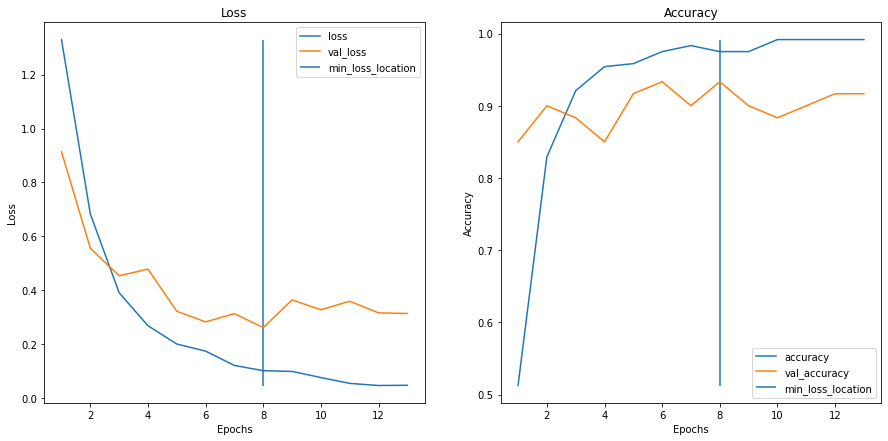

In [10]:
new_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

letter_es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

new_model_hist = new_model.fit(
    x_train_letters,
    y_train_letters,
    validation_data=(x_test_letters, y_test_letters),
    batch_size=32,
    epochs=1000,
    callbacks=[letter_es],
)
plot_training_curves(new_model_hist)